<a href="https://colab.research.google.com/github/JoyPanida/Customer-expereince-Analysis-of-Hospitals-in-Thailand/blob/main/Ramathibodi_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Sentiment Customer Experience Review**






In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os 
dir_path = os.path.dirname(os.path.realpath('/content/gdrive/My Drive/Colab Notebooks/multinomial_nb_Model.pkl'))
print(dir_path )

/content/gdrive/My Drive/Colab Notebooks


## **Import Library**

In [ ]:
#Utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
#NLP
import nltk
from nltk import sent_tokenize, word_tokenize, RegexpParser
from nltk.sentiment.util import mark_negation
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tag import pos_tag
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#Machine Learning
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# metrix classification
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, classification_report

#WordCloud
from wordcloud import WordCloud

# metric
from sklearn.metrics import classification_report

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def predict_sentiment(estimator, df):
  sentiments = []
  for sentence in df["reviews_en"]: 
    sentiment = estimator.predict([sentence])
    if sentiment == 1:
      sentiment = "positive"
    else:
      sentiment = "negative"
    sentiments.append( sentiment ) 
  return sentiments

In [ ]:
def plural2singular(word):
  if word == "doctors":
    return "doctor"
  elif word == "nurses":
    return "nurse"
  elif word == "clinics":
    return "clinic"
  elif word == "hospitals":
    return "hospital"
  elif word == "services":
    return "service"
  elif word == "staffs":
    return "staff"
  elif word == "treatments":
    return "treatment"
  elif word == "students":
    return "student"
  else:
    return word

In [ ]:
def create_parsed_trees(df):
  # Define your custom grammar (modified to be a valid regex)
  grammar = """NP: {<NN|NNS>+}
                 {<NN|NNS>+<CC><NN|NNS>+}"""

   # Create an instance of your custom parser              
  chunker = RegexpParser(grammar)

  
  parse_trees = []
  for sentence in df['reviews_en']:
      parse_trees.append(chunker.parse(pos_tag(word_tokenize(sentence))))
  return parse_trees

In [ ]:
def extract_noun_phrases(parsed_trees):
    nps = []
    for parsed_tree in parsed_trees:
      np = []
      for subtree in parsed_tree.subtrees():
          if subtree.label() == 'NP':
              t = subtree
              t = " ".join(word for word, tag in t.leaves())
              np.append(t)
      nps.append(np)
    return nps

In [ ]:
def vizwordcloud(df, colormap = 'viridis'):
    tuples = [tuple(x) for x in df.values]
    wordcloud = WordCloud(width=1000,height=800,colormap=colormap,max_words=100).generate_from_frequencies(dict(tuples))
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
def get_data_for_wordcloud(df, sentiment):
  sentiment_only = df[df["sentiments"] == sentiment].reset_index(drop=True)
  words = sum(sentiment_only["NP"].tolist(), [])
  words = [word.lower() for word in words]
  words = [plural2singular(word) for word in words]
  hist = pd.DataFrame({"words": words})
  short_sentiment = sentiment[0:3]
  hist = hist.groupby("words").size().reset_index(name="#"+short_sentiment)
  return hist

In [ ]:
def extract_sentences(df):
  sentences = []
  scores = []
  dates = []
  for index, row in df.iterrows():
    en = row["reviews_en"]
    score = row["ratings"]
    date = row["dates"]
    
    s = sent_tokenize(en)
    sentences= sentences + s
    scores = scores + [score]*len(s)
    dates = dates + [date]*len(s)
   
  return pd.DataFrame({"reviews_en": sentences, "ratings": scores, 'dates':dates})

In [ ]:
"""
        Preprocessing text for TfidfVectorizer
          - remove non-character
          - tokenization
          - stopword removal
          - lemmatization
        Parameters
        ----------
        reviews : list
             reviews of customer in hospital
        Return
        ----------
        cleaned_reviews : list
             Preprocessed Reviews  
"""
def preprocess_review(reviews): 
    cleaned_reviews = []
    for review in reviews:
        review = re.sub("[^a-zA-Z]", " ", review)
        words = word_tokenize(review) 
        tokenized_words = [(word.lower()).strip() for word in words if word not in stopwords.words("english")]
        lemmatized_word = lemmatize_word(tokenized_words)
        
        cleaned_reviews.append(lemmatized_word)
    return cleaned_reviews

In [ ]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'a'

In [ ]:
def lemmatize_word(tokenized_words): 
    lemmatizer = WordNetLemmatizer() 
    lemmatized_words = []
    for word, tag in pos_tag(tokenized_words):
        pos = get_wordnet_pos(tag)
        lemmatized_words.append(lemmatizer.lemmatize(word, pos))
    lemmatized_words = ' '.join([str(word) for word in lemmatized_words]) 
    return lemmatized_words

In [ ]:
def groups(word):

    if ("doctor" in  word) or ("nurse"  in word) or  ("student" in word) or ("guard" in word) or ("staff" in word) or ("guard"  in word) :
        return "staff"
    elif ("hospital" in word) or ("clinic" in word) or ("equipment" in word) or ("place" in word) or ("building" in word) or ("room" in word) :
        return "infrastructure"
    elif ("care"in word) or ("treatment"in word) or ( "advice"in word) or ("surgery" in word) or ("disease"in word) or ("medical care" in word) or ( "service"in word) or ("responsibility"in word) or ("manner" in word) or ("talking" in word)  :
        return "service"
    elif ("queue"in word) or  ("appointment"in word) or ("process"in word) or ("management" in word) or ("schedule"in word) :
        return "process"
    elif ("price" in word) or ( "claim"in word):
        return "finance"
    else:
        return "others"

In [ ]:
def  catagory_pos(pos_df):
    pos_df["category"] = pos_df["words"].apply(lambda x: groups(x))
    hos_poscount = pos_df.groupby("category").size().reset_index(name="count_pos")
    hos_poscount = hos_poscount[hos_poscount["category"] != "others"].reset_index(drop=True)
    return hos_poscount

In [ ]:
def  catagory_neg(neg_df):
    neg_df ["category"] = neg_df["words"].apply(lambda x: groups(x))
    hos_negcount = neg_df.groupby("category").size().reset_index(name="count_neg")
    hos_negcount =  hos_negcount[ hos_negcount["category"] != "others"].reset_index(drop=True)
    return hos_negcount

In [ ]:
def train_multinomial_nb(X_train, X_test, y_train, y_test):
     
    tfidf_vectorizer = TfidfVectorizer()
    multinomial_nb_clf = MultinomialNB()
    multinomial_naive_bayes_pipeline = Pipeline([
            ('tfidf', tfidf_vectorizer),
            ('classifier', multinomial_nb_clf)
    ])
    multinomial_naive_bayes_params = {}
    grid = GridSearchCV(multinomial_naive_bayes_pipeline, param_grid = multinomial_naive_bayes_params, cv = 10, scoring = 'roc_auc')
    grid.fit(X_train, y_train)
     
    print("Best Score : %.2f" %  grid.best_score_)
    print("Best Params : ")
    print(grid.best_params_)
    
    y_pred = grid.predict(X_test)
    print("Accuracy : %.2f" % accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    return grid.best_estimator_

In [ ]:
# def train_random_forest(X_train, X_test, y_train, y_test):
    
#     tfidf_vectorizer = TfidfVectorizer()
#     rf_clf =  RandomForestClassifier(random_state=2020, class_weight="balanced")
#     rf_pipeline = Pipeline([
#             ('tfidf', tfidf_vectorizer),
#             ('classifier', rf_clf)
#     ])
#     rf_params = {
#         "classifier__n_estimators": range(50, 200, 50),
#         "classifier__max_depth": range(2, 10, 2), 
#         "classifier__min_samples_leaf": range(1, 4)
#     }
#     grid = GridSearchCV(rf_pipeline, param_grid=rf_params, cv=10, scoring='roc_auc')
#     grid.fit(X_train, y_train) 
    
#     print("Best Score : %.2f" %  grid.best_score_)
#     print("Best Params : ")
#     print(grid.best_params_)
    
#     y_pred = grid.predict(X_test)
#     print("Accuracy : %.2f" % accuracy_score(y_test, y_pred))
#     print(classification_report(y_test, y_pred))
#     return grid.best_estimator_

# **Load the dataset**

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Thesis_Text Analytics/train_test_data_combine_translated.csv", index_col=False, header = 0, names = ['reviews', 	'ratings', 	'dates', 	'reviews_en'])

In [ ]:
df.head()

,reviews,ratings,dates,reviews_en
0,เรียนผู้อำนวยการศูนย์คลีนิคเวชกรรมอนันต์พัฒนา1...,0,2018-10-09 17:28:00,Dear Director of Anan Pattana 1 Clinic Center ...
1,โรงพยาบาลเล็กและดูเก่าเครื่องมือก็ดูจะไม่ทันสม...,0,2017-02-01 20:55:00,"The hospital is small and looks old, the equip..."
2,เจ้าหน้าให้ความสนใจต่อคนไข้เป็นอย่างดี,1,2017-01-07 08:02:00,The staff pay good attention to the patients.
3,คุณหมอใส่ใจดีมาก ไปมา3ครั้งสิวหายทั้งหลังเลย.ค...,1,2018-09-09 22:21:00,"The doctor was very attentive. Came 3 times, m..."
4,คุณหมอใส่ใจดีมาก ไปมา3ครั้งสิวหายทั้งหลังเลย.ค...,1,2018-09-09 22:20:00,"The doctor was very attentive. Came 3 times, m..."


In [ ]:
df.shape

(4055, 4)

In [ ]:
df["ratings"].value_counts()

1    2997
0    1058
Name: ratings, dtype: int64

Text(0, 0.5, 'Count')

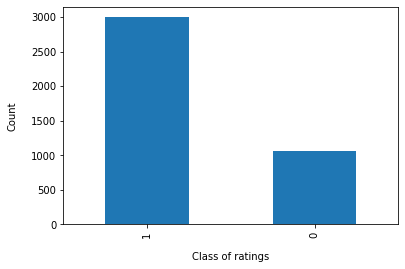

In [ ]:
df['ratings'].value_counts().plot(kind='bar');
plt.xlabel("Class of ratings", labelpad=14)
plt.ylabel("Count", labelpad=14)

## **Data Preprocessing**

**Text processing  &  Train_Test  data processing**

In [ ]:
train_test_data = df.iloc[:]
train_test_data = train_test_data.reset_index()
train_test_data = extract_sentences(train_test_data) 
train_test_data["cleaned_reviews"] = preprocess_review(train_test_data["reviews_en"])

In [ ]:
X = train_test_data["cleaned_reviews"]
y = train_test_data["ratings"]

## **Model training**

 **Multinomial Naive Bayes**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2020)

In [ ]:
multinomial_nb_classifier = train_multinomial_nb(X_train, X_test, y_train, y_test)

Best Score : 0.85
Best Params : 
{}
Accuracy : 0.78
              precision    recall  f1-score   support

           0       0.75      0.39      0.51      1344
           1       0.78      0.95      0.86      3127

    accuracy                           0.78      4471
   macro avg       0.77      0.67      0.69      4471
weighted avg       0.77      0.78      0.75      4471



In [ ]:
random_forest_classifier = train_random_forest(X_train, X_test, y_train, y_test)

Best Score : 0.82
Best Params : 
{'classifier__max_depth': 8, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 150}
Accuracy : 0.70
              precision    recall  f1-score   support

           0       0.50      0.84      0.63      1344
           1       0.90      0.64      0.75      3127

    accuracy                           0.70      4471
   macro avg       0.70      0.74      0.69      4471
weighted avg       0.78      0.70      0.71      4471



## **Selecting model and run accuracy test**

 **Load Data Ramathibodi Hospital**

In [ ]:
ramathibodi = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Thesis_Text Analytics/ramathibodi-hospital-translated.csv', 
                          index_col=False, header = 0, names = ['reviews', 'ratings', 'dates', 'reviews_en'], parse_dates= ['dates'])

In [ ]:
ramathibodi.shape

(211, 4)

In [ ]:
ramathibodi.head()

,reviews,ratings,dates,reviews_en
0,เคยได้ไปลองใช้บริการคลีนิคนอกเวลาของรามาเมื่อต...,1,2019-07-29 13:14:00,I used to try out the clinic at Rama's office ...
1,ผมเคยไปทำเลสิกที่นี้ ดีมากครับตอนนี้ผ่ามาจะ2ปี...,1,2019-02-08 12:46:00,"I've been to LASIK here. Very good, now it has..."
2,รักษามาหลายปีแล้วตั้งแต่อายุ14 ตอนนี้จะจบปริญญ...,1,2019-01-17 21:48:00,Healed many years since the age of 14 Now I wi...
3,รักษามาหลายปีแล้วตั้งแต่อายุ14 ตอนนี้จะจบปริญญ...,1,2019-01-17 21:48:00,Healed many years since the age of 14 Now I wi...
4,Its a public hospital so service is bad (nurse...,1,2018-12-24 14:48:00,Its a public hospital so service is bad (nurse...


In [ ]:
ramathibodi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   reviews     211 non-null    object        
 1   ratings     211 non-null    int64         
 2   dates       211 non-null    datetime64[ns]
 3   reviews_en  211 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 6.7+ KB


In [ ]:
ramathibodi["ratings"].value_counts()

1    165
0     46
Name: ratings, dtype: int64

Text(0, 0.5, 'Count')

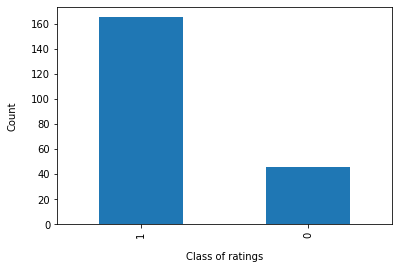

In [ ]:
ramathibodi['ratings'].value_counts().plot(kind='bar');
plt.xlabel("Class of ratings", labelpad=14)
plt.ylabel("Count", labelpad=14)

## **Data Prepocessing**

In [ ]:
#Date string to Datetimestamp
ramathibodi['dates'] = pd.to_datetime(ramathibodi["dates"].dt.strftime('%Y-%m'))

#Distinct date
dt_date = list(set(ramathibodi['dates']))
dt_date.sort()

# convert date to  string and sort
from datetime import datetime
date_time_obj = [str(x)[:7]  for x in dt_date]
print(date_time_obj)

['2017-01', '2017-02', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-07']


In [ ]:
# create dataframe and extract data everymonth
from dateutil.relativedelta import relativedelta
for d in date_time_obj:
    start = datetime.strptime(d , '%Y-%m')
    end = datetime.strptime(d , '%Y-%m')+ relativedelta(months=1) 
    
    mask = (ramathibodi['dates'] >= start) & (ramathibodi['dates'] < end)
    df = pd.DataFrame(ramathibodi.loc[mask])
    
    d = re.sub('-', '', d)
    exec("df" + d + " = df") 

## **Modeling and Evaluation**  
**Multinomial Naive Bayes**

In [ ]:
list_df = ['df201701', 'df201702', 'df201808', 'df201809', 'df201810', 'df201811', 'df201812', 'df201901', 'df201902', 'df201907']

frames = []
word_and_catagory  = []

for month_df in list_df:
    df_name  = globals()[month_df]
 
    ramamonth_df = extract_sentences(df_name)
    ramamonth_df["cleaned_reviews"] = preprocess_review(ramamonth_df["reviews_en"])
    ramamonth_df["sentiments"] = predict_sentiment(multinomial_nb_classifier ,ramamonth_df)
    ramamonth_df["NP"] = extract_noun_phrases(create_parsed_trees(ramamonth_df))
    # print(ramamonth_df)

    
    #Evalution model
    print(month_df)
    y_true = ramamonth_df['ratings']
    y_pred = list(ramamonth_df['sentiments'])
    y_pred = [1 if x == 'positive' else 0 for x in y_pred]
    # print(classification_report(y_true, y_pred))

    #vizwordcloud(df_pos)
    df_pos = get_data_for_wordcloud(ramamonth_df, "positive")
    #vizwordcloud(df_neg)
    df_neg = get_data_for_wordcloud(ramamonth_df, "negative")
    
   # word in catagory of df_pos and df_neg
    word_and_catagory.append(df_pos)
    word_and_catagory.append(df_neg)

    #poscount
    ramathibodi_poscount = catagory_pos(df_pos)                 
    ramathibodi_negcount = catagory_neg(df_neg)
    
    
    # Create DataFrame  
    tmp_df = pd.DataFrame({'category': ['finance', 'infrastructure', 'process', 'service', 'staff']})
    all_count_df = tmp_df.merge( ramathibodi_poscount.merge(ramathibodi_negcount, left_on='category', right_on='category', how='left', suffixes=('_pos', '_neg')), left_on='category', right_on='category', how='left', suffixes=('', ''))
    all_count_df['date'] =  datetime.strptime(month_df[-6:] , '%Y%m')

    all_count_df['count_pos'] = all_count_df['count_pos'].fillna(0)
    all_count_df['count_neg'] = all_count_df['count_neg'].fillna(0)
    all_count_df['total'] = all_count_df['count_pos'] + all_count_df['count_neg']

    # append datframe to combine df
    frames.append(all_count_df)

    all_count_df = all_count_df.astype({"category": str, "count_pos": str, "count_neg": str, "total": str})
    print(all_count_df)
    print('-----------------------------------------------------------------------------------------------------')


df201701
         category count_pos count_neg       date total
0         finance         1       0.0 2017-01-01   1.0
1  infrastructure        29      10.0 2017-01-01  39.0
2         process         7       4.0 2017-01-01  11.0
3         service        21       6.0 2017-01-01  27.0
4           staff        16       5.0 2017-01-01  21.0
-----------------------------------------------------------------------------------------------------
df201702
         category count_pos count_neg       date total
0         finance       0.0       0.0 2017-02-01   0.0
1  infrastructure       7.0       0.0 2017-02-01   7.0
2         process       5.0       0.0 2017-02-01   5.0
3         service       9.0       0.0 2017-02-01   9.0
4           staff       5.0       0.0 2017-02-01   5.0
-----------------------------------------------------------------------------------------------------
df201808
         category count_pos count_neg       date total
0         finance       0.0       0.0 2018-08-01   0.0

In [ ]:
#check  word to separate category
concated = pd.DataFrame({'words' : [],
                                        '#pos' : [],
                                        'category' : []
                                         } )

for  view in word_and_catagory:
  concated = pd.concat([concated,view], axis=0)
concated
concated.to_csv("word_and_catagory.csv", index=False, encoding='utf-8-sig')


In [ ]:
#concate dataframe
result_concate = pd.concat(frames)
print(result_concate)
result_concate.to_csv("ramathibodi_report_per_month.csv", index=False, encoding='utf-8-sig')

         category  count_pos  count_neg       date  total
0         finance        1.0        0.0 2017-01-01    1.0
1  infrastructure       29.0       10.0 2017-01-01   39.0
2         process        7.0        4.0 2017-01-01   11.0
3         service       21.0        6.0 2017-01-01   27.0
4           staff       16.0        5.0 2017-01-01   21.0
0         finance        0.0        0.0 2017-02-01    0.0
1  infrastructure        7.0        0.0 2017-02-01    7.0
2         process        5.0        0.0 2017-02-01    5.0
3         service        9.0        0.0 2017-02-01    9.0
4           staff        5.0        0.0 2017-02-01    5.0
0         finance        0.0        0.0 2018-08-01    0.0
1  infrastructure        2.0        0.0 2018-08-01    2.0
2         process        1.0        0.0 2018-08-01    1.0
3         service        1.0        0.0 2018-08-01    1.0
4           staff        1.0        0.0 2018-08-01    1.0
0         finance        0.0        0.0 2018-09-01    0.0
1  infrastruct

# **Sentiment Analysis of Ramathibodi Hospital** (Overview)

In [ ]:
ramathibodi_copy = ramathibodi
ramathibodi_copy = ramathibodi_copy.reset_index()
ramathibodi_copy = extract_sentences(ramathibodi_copy) 
ramathibodi_copy["cleaned_reviews"] = preprocess_review(ramathibodi_copy["reviews_en"])

In [ ]:
ramathibodi_copy["sentiments"] = predict_sentiment(multinomial_nb_classifier ,ramathibodi_copy)

In [ ]:
ramathibodi_copy["NP"] = extract_noun_phrases(create_parsed_trees(ramathibodi_copy))

In [ ]:
ramathibodi_copy.head(10)

,reviews_en,ratings,dates,cleaned_reviews,sentiments,NP
0,I used to try out the clinic at Rama's office ...,1,2019-07-01,i use try clinic rama office earlier year,positive,"[clinic, office, year]"
1,Got into the upper laser treatment in the face...,1,2019-07-01,get upper laser treatment face phisobsol docto...,positive,"[laser treatment, face, doctor, kind]"
2,The queue is not long.,1,2019-07-01,the queue long,positive,[queue]
3,But have to call to reserve in advance Doctor'...,1,2019-07-01,but call reserve advance doctor love education...,positive,"[advance, love education]"
4,Less than 5 minutes to treat The results that ...,1,2019-07-01,less minute treat the result come marks face d...,positive,"[minutes, results, marks, face]"
5,The care of the nurse is not expensive too.,1,2019-07-01,the care nurse expensive,positive,"[care, nurse]"
6,I've been to LASIK here.,1,2019-02-01,i lasik,positive,[]
7,"Very good, now it has been surgery for 2 years...",1,2019-02-01,very good surgery year side effect price also ...,positive,"[years, side effects, price]"
8,"During the operation, it may seem a bit scary.",1,2019-02-01,during operation may seem bit scary,positive,"[operation, bit]"
9,"But when it's time to dissect, it actually doe...",1,2019-02-01,but time dissect actually feel pain,positive,"[time, pain]"


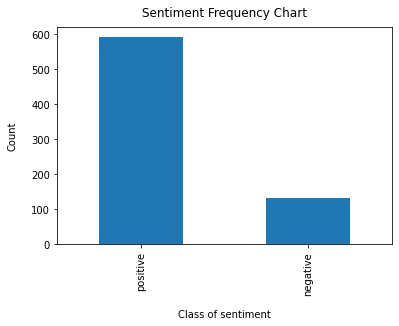

In [ ]:
ramathibodi_copy['sentiments'].value_counts().plot(kind='bar', figsize=(6, 4));
plt.xlabel("Class of sentiment", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Sentiment Frequency Chart", y=1.02);

In [ ]:
y_true = ramathibodi_copy['ratings']
y_pred = list(ramathibodi_copy['sentiments'])
y_pred = [1 if x == 'positive' else 0 for x in y_pred]
print(classification_report(y_true, y_pred))
print("Accuracy : %.2f" % accuracy_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.42      0.51       214
           1       0.79      0.91      0.85       511

    accuracy                           0.77       725
   macro avg       0.73      0.66      0.68       725
weighted avg       0.75      0.77      0.75       725

Accuracy : 0.77


In [ ]:
 #vizwordcloud(df_pos)
df_pos = get_data_for_wordcloud(ramathibodi_copy, "positive")
#vizwordcloud(df_neg)
df_neg = get_data_for_wordcloud(ramathibodi_copy, "negative")

In [ ]:
ramathibodi_positive = get_data_for_wordcloud(ramathibodi_copy, "positive")
# vizwordcloud(ramathibodi_positive)

In [ ]:
ramathibodi_negative = get_data_for_wordcloud(ramathibodi_copy, "negative")
# vizwordcloud(ramathibodi_negative, "inferno")

In [ ]:
# df_pos
df_pos = df_pos.sort_values(by=['#pos'], ascending=False)

In [ ]:
# df_neg
df_neg = df_neg.sort_values(by=['#neg'], ascending=False)

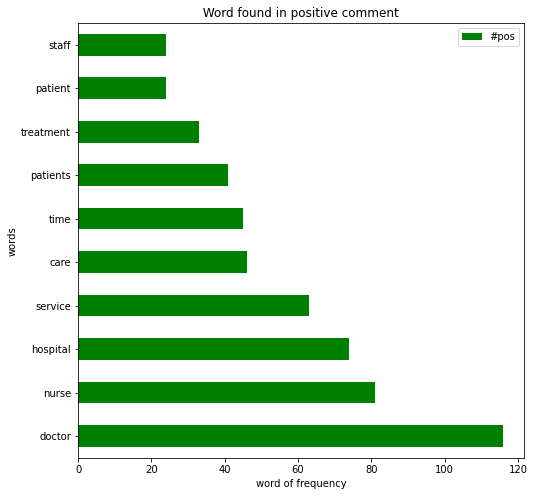

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
# Plot horizontal bar graph
df_pos[0:10].plot.barh(x='words', y='#pos',  ax=ax, color="green")
ax.set_title(" Word found in positive comment ")
ax.set_xlabel("word of frequency")
plt.show()

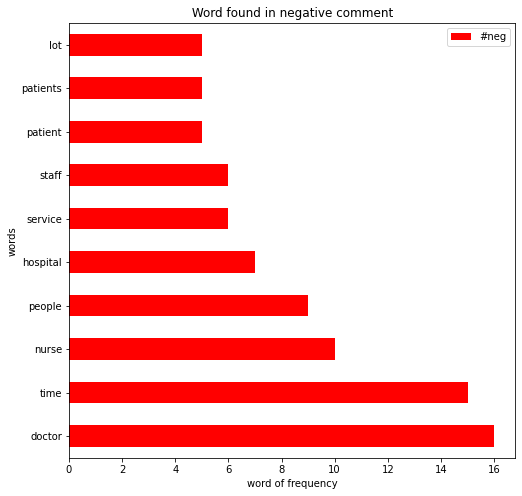

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
# Plot horizontal bar graph
df_neg[0:10].plot.barh(x='words', y='#neg',  ax=ax, color="red")
ax.set_title(" Word found in negative comment ")
ax.set_xlabel("word of frequency")
plt.show()
plt.show()